<a href="https://colab.research.google.com/github/amura/xray-machinelearning/blob/model_evaluation/performance_evaluation_xrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun 21 05:55:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import required dependencies
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
from PIL.ImageStat import Stat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import cv2

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!pip list | grep tensorflow

tensorflow                    2.5.0              
tensorflow-datasets           4.0.1              
tensorflow-estimator          2.5.0              
tensorflow-gcs-config         2.5.0              
tensorflow-hub                0.12.0             
tensorflow-metadata           1.0.0              
tensorflow-probability        0.12.1             


In [5]:
# setup drive
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/ML"

In [7]:
#changing the working directory
%cd /content/gdrive/MyDrive/ML

/content/gdrive/MyDrive/ML


In [8]:
# install utility for converting to dicom
!pip install simpleitk  > /dev/null 2>&1

# Load 2 trained models

In [9]:
# Load the csv back in to a dataframe

data = pd.read_csv('/content/gdrive/MyDrive/C19/dicom/x-ray-scans.csv')
# convert label from string to int
mapping = {'non-covid': '0', 'covid': '1'}
data = data.replace({'label': mapping})
data.head()

,Unnamed: 0,paths,label
0,0,/content/gdrive/MyDrive/C19/dicom/covid/c_2616...,1
1,1,/content/gdrive/MyDrive/C19/dicom/covid/c_2617...,1
2,2,/content/gdrive/MyDrive/C19/dicom/covid/c_2618...,1
3,3,/content/gdrive/MyDrive/C19/dicom/covid/c_2619...,1
4,4,/content/gdrive/MyDrive/C19/dicom/covid/c_2620...,1


In [10]:
from sklearn.model_selection import train_test_split
# split data 20% test

train_set, test_set = train_test_split(data, test_size=0.2)

In [11]:
# Data augmentation
validation_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                              validation_split = 0.2)

test_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

In [12]:
# install pydicom
!pip install pydicom

     |████████████████████████████████| 1.9MB 4.3MB/s 


In [13]:
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
import pydicom

#DICOM image reader
# https://gist.github.com/ReemRashwan/8c92086d3104d01978a16e05ca93a165
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(224, 224), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)

        return image_array

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 224
img_width = 224
class_mode = 'binary'
colour_mode = 'rgb'
seed = 1234
num_epochs = 30

valid_consts = {
   'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width), 
    'shuffle': False
}

validation_generator = DCMDataFrameIterator(dataframe=train_set,
                            x_col='paths',
                             y_col='label',                            
                             image_data_generator=validation_datagen,
                             **valid_consts)



Found 2123 validated image filenames belonging to 2 classes.


In [25]:


# Using the testing generator to evaluate the model after training

test_generator = DCMDataFrameIterator(dataframe=test_set,
                             x_col='paths',
                             y_col='label',   
                             image_data_generator=test_datagen,
                             **test_consts)

#test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))


Found 2654 validated image filenames belonging to 2 classes.


### Build resnet50 model and load weights

In [15]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow.keras.layers as layers
from keras.initializers import glorot_uniform

In [16]:
from keras.applications.resnet50 import ResNet50
resnet50BaseModel = ResNet50(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))


94773248/94765736 [==============================] - 2s 0us/step


In [17]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
# freeze the top layers
resnet50BaseModel.trainable = False

#configure the classification layer 
modelResnet50 = keras.Sequential([
  resnet50BaseModel,
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dense(4096, activation='relu'),
  layers.Dense(2, activation='softmax')                          
])

# load the training weights
modelResnet50.load_weights(filepath='/content/gdrive/MyDrive/C19/resnet50.hdf5')

In [26]:
# Run predictions on training set
y_pred = modelResnet50.predict(test_generator).ravel()


array([[9.8428345e-01, 1.5716495e-02],
       [9.9999130e-01, 8.7443777e-06],
       [9.9981517e-01, 1.8482156e-04],
       ...,
       [9.9968135e-01, 3.1870004e-04],
       [9.9999666e-01, 3.3649610e-06],
       [9.4261360e-01, 5.7386372e-02]], dtype=float32)

### Build VGG16 model and load weights

In [ ]:
from keras.applications.vgg16 import VGG16
vgg16BaseModel = VGG16(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
# freeze the top layers
vgg16BaseModel.trainable = False

#configure the classification layer 
modelVgg16 = keras.Sequential([
  vgg16BaseModel,
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dense(4096, activation='relu') ,
  layers.Dense(2, activation='softmax')                          
])

modelVgg16.build(input_shape=(None,img_width, img_height, 3))

modelVgg16.load_weights(filepath='/content/gdrive/MyDrive/C19/vggModel')

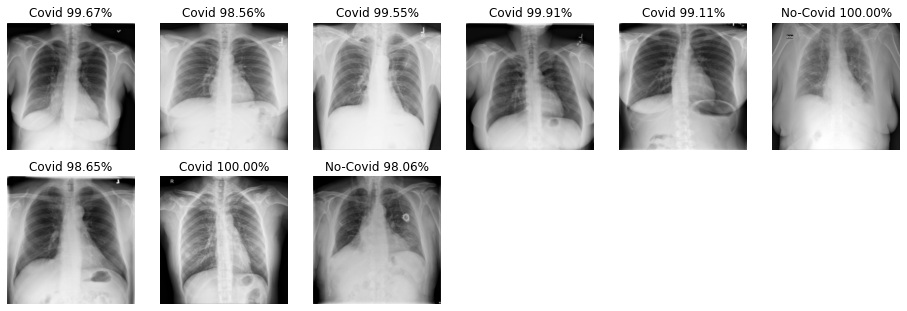

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 8))
for i in range(9):
    x, y = test_generator.next()
    prediction = model.predict(np.expand_dims(x[0], axis=0))[0]
    
    plt.subplot(3, 6, i+1)
    if prediction[0] > prediction[1]:
        plt.title('Covid %.2f%%' % (prediction[0]*100))
    else:
        plt.title('No-Covid %.2f%%' % (prediction[1]*100))
    
    plt.axis('off')
    plt.imshow(x[0])